data: willhaben: apartments for sale in vienna (no other filters)

In [88]:
from pathlib import Path
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


sns.set(style="whitegrid")
%matplotlib inline
pd.options.display.float_format = '{:.0f}'.format


files = (Path.cwd() / "data").iterdir()
files = sorted(files, key=lambda x: x.name)
file = files[-1]
print(f"reading {file}")
df = pd.read_csv(file, delimiter=";")


def clean_up(df: pd.DataFrame) -> pd.DataFrame:
    df = df.drop(columns=["link", "title"])

    df["address"] = df["address"].str.extract(r"(\d{4})").replace(np.nan, 0).astype(int)

    df["price"] = df["price"].str.replace(r"[^\d.,]", "", regex=True) # only keep numbers, point and comma
    df["price"] = df["price"].str.replace(r"\.", "", regex=True) # remove thousand separator
    df["price"] = df["price"].str.replace(r",", ".", regex=True) # convert comma to point
    df["price"] = df["price"].astype(float)

    df["m2"] = df["m2"].str.extract(r"(\d+)").astype(float)

    df["num_rooms"] = df["num_rooms"].str.extract(r"(\d+)").astype(float)

    df["type"] = df["type"].str.lower()

    return df


df = clean_up(df)
df.head()

reading /Users/sueszli/dev/will-wohnen/data/links_2024-05-25_14-46-15.csv


,address,price,m2,num_rooms,type
0,1210,425000,67,3,balkon
1,1210,284900,86,3,garten
2,1200,439000,76,3,NaN
3,1070,1300000,115,3,"terrasse, balkon"
4,1020,249000,55,2,NaN


# summary stats

In [89]:
print(f"""
total: {len(df)}
------------------------
{df["price"].describe()}
------------------------
{df["m2"].describe()}
------------------------
{df["num_rooms"].describe()}
""")


total: 5751
------------------------
count       5639
mean      571277
std       756685
min          505
25%       295000
50%       398900
75%       589000
max     15900000
Name: price, dtype: float64
------------------------
count   5524
mean      75
std       48
min        2
25%       48
50%       64
75%       86
max      870
Name: m2, dtype: float64
------------------------
count   5411
mean       3
std        1
min        1
25%        2
50%        2
75%        3
max       27
Name: num_rooms, dtype: float64



# visualizations

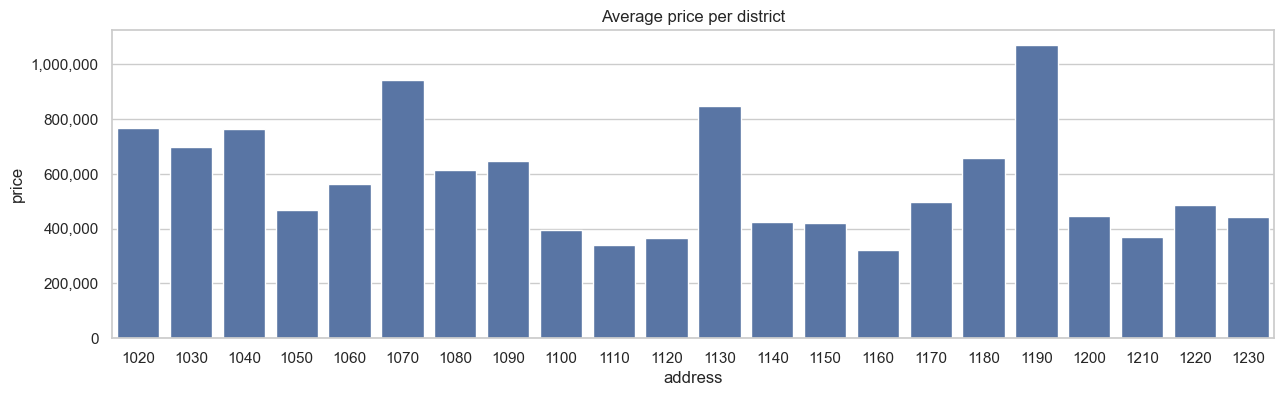

In [71]:
copy = df.copy()
copy = copy[copy["address"] != 0]
copy = copy.groupby("address")["price"].mean().reset_index()
copy = copy.sort_values(by="price", ascending=False)

# drop 1010
copy = copy[copy["address"] != 1010]

plt.figure(figsize=(15, 4))
plt.gca().get_yaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))

sns.barplot(x="address", y="price", data=copy)
plt.title("Average price per district")
plt.show()

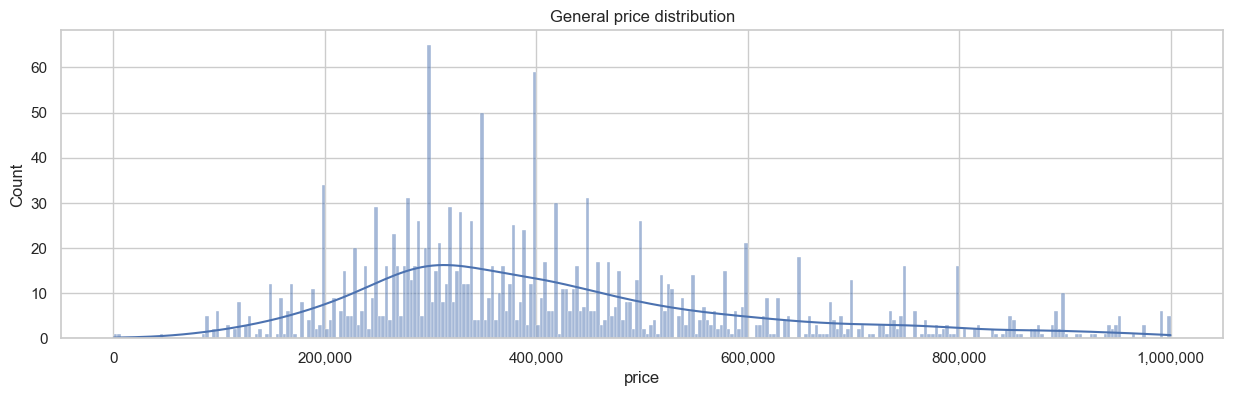

In [72]:
copy = df.copy()

# remove outliers
copy = copy[copy["price"] < 1_000_000]

plt.figure(figsize=(15, 4))
sns.histplot(copy["price"], bins=300, kde=True)
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
plt.title("General price distribution")
plt.show()

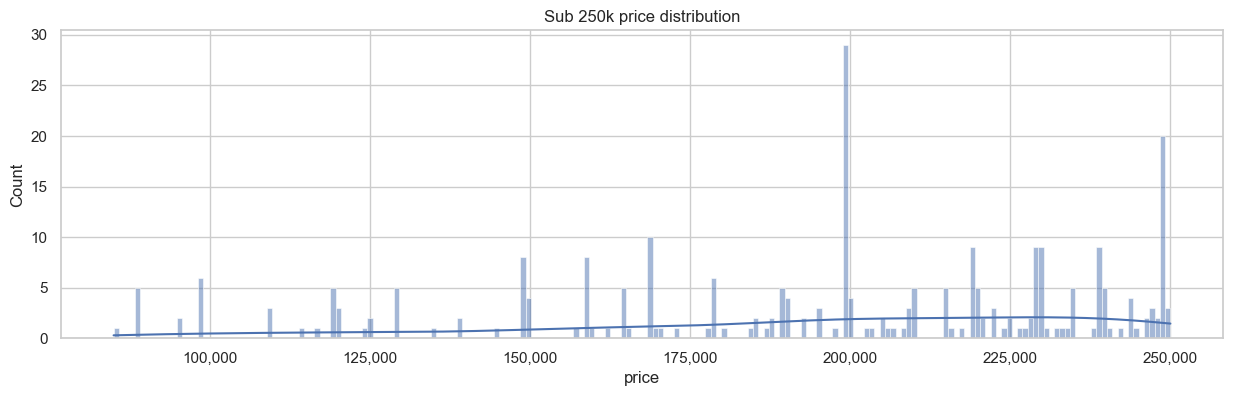

In [73]:
copy = df.copy()

# remove outliers
copy = copy[copy["price"] > 50_000]
copy = copy[copy["price"] < 250_000]

plt.figure(figsize=(15, 4))
sns.histplot(copy["price"], bins=200, kde=True)
plt.gca().get_xaxis().set_major_formatter(plt.FuncFormatter(lambda x, _: format(int(x), ',')))
plt.title("Sub 250k price distribution")
plt.show()